In [84]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

gender_sub = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
train = pd.read_csv('/kaggle/input/titanic/train.csv')
train


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### **Column Descriptions**

**Survived:** Binary. 0 for not survived, 1 for survived.  
**Pclass:** Passenger class on the ship. 1 for first, 2 for second, 3 for third.  
**Name:** Name of the passenger.  
**Sex:** Sex of the passenger.  
**Age:** Age in years of the passenger.  
**SibSp:** Siblings or spouses per passenger.  
**Parch:** Parents or children per passenger.  
**Ticket:** Code of passenger ticket.  
**Fare:** Amount spend on the trip.  
**Cabin:** Cabin number in the ship.  
**Embarked:** Local of boarding. S for Southampton, C for Cherbourg, and Q for Queenstown  

In [85]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## **Previous Analysis**

Let´s take a look at the general analysis of the data. We're gonna generate visualizations based on the main features. Since our information target is the surviving condition, seems pertinent to analyse the statistics involving the other features related with survivance numbers.

In [86]:
#Preparing a dataset copy for analysis
import matplotlib.pyplot as plt
import seaborn as sns

df_analysis = train.copy()
df_analysis['Condition'] = df_analysis['Survived'].apply(lambda x: 'Survived' if x == 1 else 'Died')
df_analysis['Age'].fillna(int(df_analysis['Age'].mean()), inplace=True)
df_analysis


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Condition
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Died
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Survived
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Survived
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Survived
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Died
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Died
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Survived
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.0,1,2,W./C. 6607,23.4500,NaN,S,Died
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Survived


In [97]:
def plot_group_chart(data, x, y, title, metric, hue, palette):
    sns.set_theme(style="whitegrid")
    g = sns.catplot(
        data=data, kind="bar",
        x=x, y=y, hue=hue,
        ci="sd", palette=palette, alpha=.6, height=6)
    g.despine(left=True)
    g.set(title=title)
    g.set_axis_labels("", metric + " Passengers")


In [88]:
def plotly_group_bar(data):
    plot = px.Figure(data=[
    px.Bar(name = data['name1'], x = data['xdata'], y = data['data1'], marker=dict(color=data['color1'])),
    px.Bar(name = data['name2'], x = data['xdata'], y = data['data2'], marker=dict(color=data['color2']))])

    plot.layout.update({
                       'margin': {'t': 40, 'b': 20, 'l': 20, 'r': 20},
                       'width': 600,
                       'height': 400})
    # plot.update_layout(paper_bgcolor='rgba(0,0,0,0)',
    #                    title={'font': {'color': 'white'}},
    #                    xaxis_title={'font': {'color': 'white'}},
    #                    yaxis_title={'font': {'color': 'white'}})
    return plot

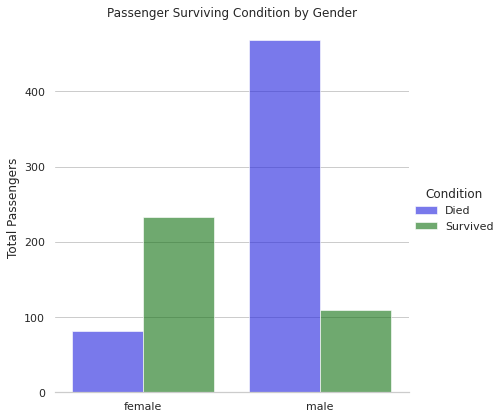

In [98]:
#Survivors Statistics by Gender
sum_data = df_analysis.groupby(["Sex", "Condition"])["PassengerId"].count().reset_index()
plot_group_chart(sum_data, "Sex", "PassengerId",'Passenger Surviving Condition by Gender', "Total", 'Condition', ["blue", "green"])


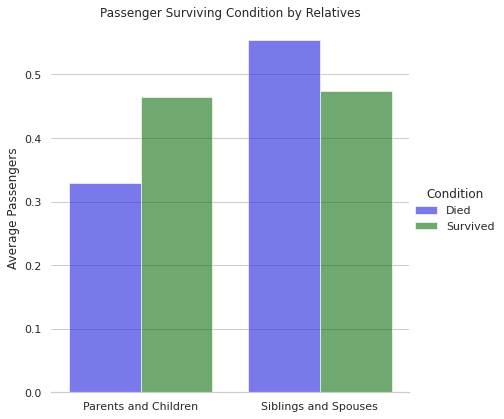

In [99]:
#Surviving Statistics Based on The Relatives
sum_data_parch = df_analysis.groupby(["Condition"])["Parch"].mean().reset_index()
sum_data_parch.rename(columns={'Parch': 'Mean'}, inplace=True)
sum_data_parch['Type'] = "Parents and Children"
sum_data_sbsp = df_analysis.groupby(["Condition"])["SibSp"].mean().reset_index()
sum_data_sbsp.rename(columns={'SibSp': 'Mean'}, inplace=True)
sum_data_sbsp['Type'] = "Siblings and Spouses"
sum_data = pd.concat([sum_data_parch, sum_data_sbsp])

plot_group_chart(sum_data, "Type", "Mean",'Passenger Surviving Condition by Relatives', "Average", 'Condition', ["blue", "green"])


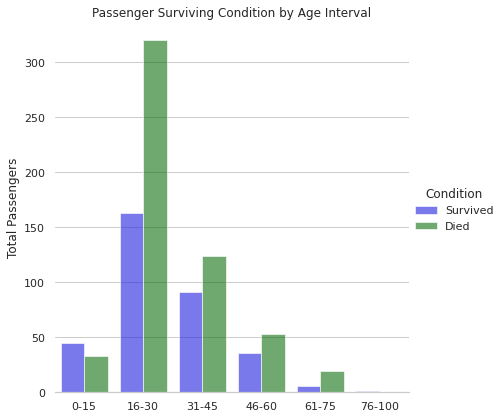

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

labels_age = ['0-15', '16-30', '31-45', '46-60', '61-75', '76-100']
df_analysis["Age_Interval"] = pd.cut(df_analysis["Age"], bins=[0, 15, 30, 45, 60, 75, 100], right=False, labels=labels_age)
age_analysis_survived = df_analysis[df_analysis['Survived'] == 1].groupby(["Age_Interval"])["Survived"].count().reset_index()
age_analysis_survived.rename(columns={'Survived': 'Count'}, inplace=True)
age_analysis_died = df_analysis[df_analysis['Survived'] == 0].groupby(["Age_Interval"])["Survived"].count().reset_index()
age_analysis_died.rename(columns={'Survived': 'Count'}, inplace=True)
age_analysis = pd.concat([age_analysis_survived, age_analysis_died], axis=0)
age_analysis['Condition'] = (['Survived'] * 6) + (['Died'] * 6)

plot_group_chart(age_analysis, "Age_Interval", "Count",'Passenger Surviving Condition by Age Interval', "Total", 'Condition', ["blue", "green"])



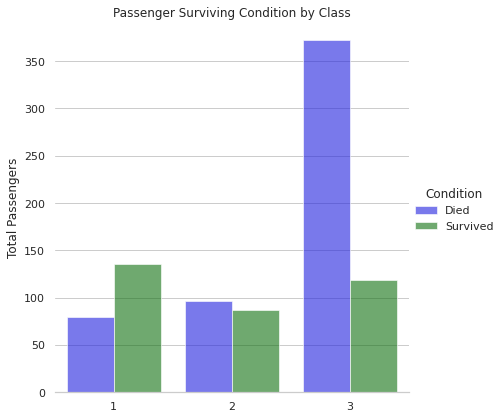

In [101]:
#Survivors Statistics by Class
sum_data = df_analysis.groupby(["Pclass", "Condition"])["PassengerId"].count().reset_index()
plot_group_chart(sum_data, "Pclass", "PassengerId",'Passenger Surviving Condition by Class', "Total", 'Condition', ["blue", "green"])


In [94]:
sum_data

,Pclass,Condition,PassengerId
0,1,Died,80
1,1,Survived,136
2,2,Died,97
3,2,Survived,87
4,3,Died,372
5,3,Survived,119


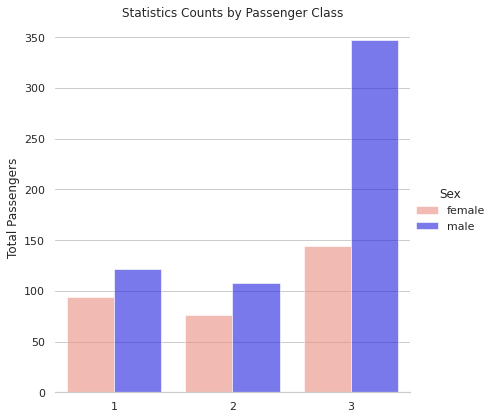

In [105]:
import plotly.graph_objects as px
import numpy

sum_data = df_analysis.groupby(['Pclass', 'Sex']).count().reset_index()
plot_group_chart(sum_data, "Pclass", "PassengerId",'Statistics Counts by Passenger Class', "Total", 'Sex', ["salmon", "blue"])

# classes = list(set(agregate.Pclass))
# female = list(agregate[agregate.Sex == 'female']['PassengerId'])
# male = list(agregate[agregate.Sex == 'male']['PassengerId'])

# plot = plotly_group_bar({'name1': 'Female', 'name2': 'Male', 'xdata': classes, 
#                          'data1': female, 'data2': male, 'color1': '#fca9f8', 'color2': '#6b6efa'})

# plot.update_layout(title='Statistics Counts Per Passenger Class',
#                     xaxis_title='Passenger Class',
#                     yaxis_title='Count',)
# plot.show(renderer='iframe')


In [95]:
sum_data

,Pclass,Sex,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Condition
0,1,female,94,94,94,94,94,94,94,94,81,92,94
1,1,male,122,122,122,122,122,122,122,122,95,122,122
2,2,female,76,76,76,76,76,76,76,76,10,76,76
3,2,male,108,108,108,108,108,108,108,108,6,108,108
4,3,female,144,144,144,144,144,144,144,144,6,144,144
5,3,male,347,347,347,347,347,347,347,347,6,347,347


## **Cleaning and Encoding**

The columns 'Name', 'Ticket', 'Cabin' and 'Embarked' don't necessarily presents great contribution to the prediction, since they are not atributes to configure advantages or disvantages of survival. So, we delete this fields from the dataset.    

Afterwords, once the only field containing relevant missing values is "Age", let's fill this missing data with the average age of the total.

In [10]:
def cleaning_missing(df_pure):
    df = df_pure.copy()
    df.Age.fillna(int(df.Age.mean()), inplace=True)
    df.Fare.fillna(df.Fare.mean(), inplace=True)
    df.drop(columns=['Name','Ticket', 'Cabin', 'Embarked'], inplace=True)
    if 'Survived' in list(df.columns):
        return df.drop(columns=['Survived']), pd.DataFrame(df['Survived']).values.ravel()
    else:
        return df, None

Now, we can start the encode process with the features. For qualitative fields, the appropriate method is the Dummy conversion. Let's create new variables for each category data.    

For that, let's use two Scikit Learn library tools called OneHotEncoder, for encode fields in binaries, and ColumnTransformer, for column creations.

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def encoding_data(df_cleaned):
    pssg_id = list(df_cleaned['PassengerId'])
    df_cleaned.drop(columns=['PassengerId'], inplace=True)
    df_coded = pd.DataFrame(ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [0, 1])], remainder='passthrough')
                            .fit_transform(df_cleaned))
    df_coded.drop(columns=4, axis=1, inplace=True) # deleting the extra column for Sex. Now, 1 is Female, 0 is Male.
    df_coded['Id'] = pssg_id
    return df_coded

Now, let's scalling the features, so the average will be next to 0 and standard deviation next to 1. It will garant more fidelity to the model.

In [12]:
from sklearn.preprocessing import StandardScaler

def scalling_df(df_coded):
    df_coded_esc = pd.DataFrame(StandardScaler().fit_transform(df_coded))
    return df_coded_esc

So, it's time to define the training and test procedures for all types of models we'll use.

In [13]:
def metrics_validation(model, trainX, trainY):    
    type_metrics = ['accuracy', 'precision_macro', 'recall_macro']
    metrics = cross_validate(model, trainX, trainY, cv=20, scoring=type_metrics)
    dict_metrics = {met: metrics[met] for met in metrics}
    # fit_time, score_time, test_accuracy, test_precision_macro, test_recall_macro

    print(f' -- Accuracy -- Avg: {np.mean(dict_metrics["test_accuracy"])} Std: {np.std(dict_metrics["test_accuracy"])}')
    print(f' -- Fit -- Avg: {np.mean(dict_metrics["fit_time"])} Std: {np.std(dict_metrics["fit_time"])}')
    print(f' -- Score -- Avg: {np.mean(dict_metrics["score_time"])} Std: {np.std(dict_metrics["score_time"])}')
    print(f' -- Recall -- Avg: {np.mean(dict_metrics["test_recall_macro"])} Std: {np.std(dict_metrics["test_recall_macro"])}')

    return dict_metrics

In [14]:
def data_preparation(data):
    data_clean, dataY = cleaning_missing(data)
    data_encoded = encoding_data(data_clean)
    dataX = scalling_df(data_encoded.iloc[: , :-1]).to_numpy()
    
    return dataX, dataY

In [15]:
def training_validation(model, data):
    trainX, trainY = data_preparation(data)

    dict_metrics = metrics_validation(model, trainX, trainY)
    
    fig = plt.figure(figsize=(12,5))
    sns.set(rc={'axes.facecolor':'white'})
    ax = fig.add_subplot()
    ax.set_ylim(0.5, 1)
    sns.lineplot(data = pd.DataFrame(dict_metrics))

    
    return trainX, trainY, dict_metrics

In [16]:
def test_prediction(model, data):
    data['Survived'] = ''
    df_for_test, _ = cleaning_missing(data)
    df_t_encoded = encoding_data(df_for_test)
    testX = scalling_df(df_t_encoded.iloc[: , :]).to_numpy()

    prediction = pd.DataFrame({'PassengerId': df_t_encoded.Id})
    prediction['Survived'] = model.predict(testX)
    return prediction

## Analysing Variable Corelation on Dataset

In [17]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [18]:
data_clean, dataY = cleaning_missing(train)
dataX = encoding_data(data_clean)

train_dummified = pd.concat([dataX, pd.DataFrame(dataY)], axis=1)
train_dummified.columns = ['1st', '2nd', '3rd', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Id', 'Target']

**Pearson's Correlation Matrix:** 

Text(0.5, 1.0, 'Correlation Matrix')

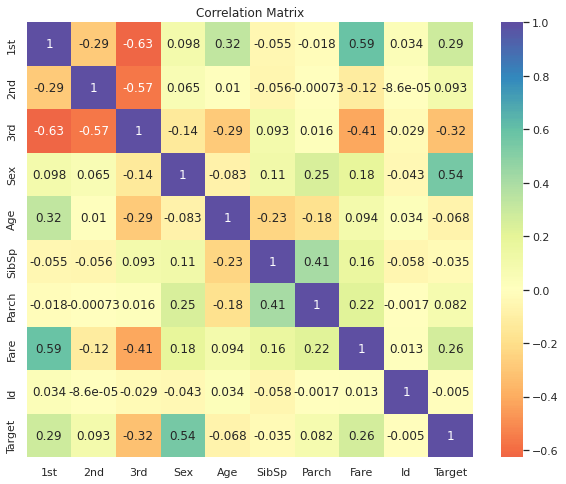

In [19]:
matrix = train_dummified.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='Spectral', center=0)
plt.title("Correlation Matrix")

**Mutual Info Score and Q² Coefficient by KBest Scores:**

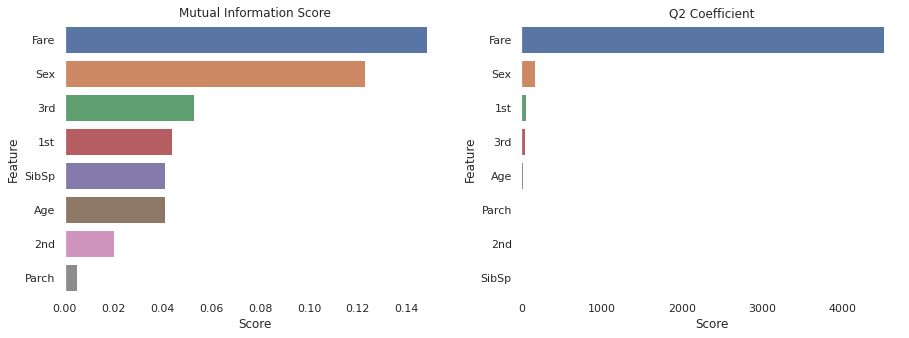

In [37]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

def plot_scores(ax, metric):
    def get_scores(metric):
        selector = SelectKBest(score_func=metric, k=1).fit(train_dummified.drop(columns={'Target'}), train_dummified['Target'])
        scores = pd.DataFrame(columns=['cols', 'scores'])
        scores['cols'], scores['scores'] = train_dummified.columns[:-2], selector.scores_[:-1]
        return scores
    
    sns.barplot(data=get_scores(metric).sort_values(by='scores', ascending=False), y='cols', x='scores', ax = ax)
    ax.set_title('Mutual Information Score') if metric is mutual_info_classif else ax.set_title('Q2 Coefficient')
    ax.set_xlabel('Score')
    ax.set_ylabel('Feature')

fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey = False, figsize = (15, 5))
plot_scores(ax1, mutual_info_classif)
plot_scores(ax2, chi2)


In [21]:
train_dummified.head(3)

,1st,2nd,3rd,Sex,Age,SibSp,Parch,Fare,Id,Target
0,0.0,0.0,1.0,0.0,22.0,1.0,0.0,7.2500,1,0
1,1.0,0.0,0.0,1.0,38.0,1.0,0.0,71.2833,2,1
2,0.0,0.0,1.0,1.0,26.0,0.0,0.0,7.9250,3,1


In [22]:
selector = SelectKBest(score_func=mutual_info_classif, k=8)
feat_selected = selector.fit_transform(train_dummified.drop(columns={'Target'}), train_dummified['Target'])
selector.get_support(indices=False)

array([ True, False,  True,  True,  True,  True,  True,  True,  True])

## **Training the Model Naive Bayes**

Let's create the model Naive Bayes that will be trained and tested with the dataset. After, we will train this model with the cross validate method, using the Scikit Learn library.

 -- Accuracy -- Avg: 0.7522474747474748 Std: 0.056834559929028146
 -- Fit -- Avg: 0.0011095285415649414 Std: 0.00014388102181988075
 -- Score -- Avg: 0.002301025390625 Std: 0.00016669553927530054
 -- Recall -- Avg: 0.7172424525365702 Std: 0.06299796747850211


GaussianNB()

<Figure size 1080x1440 with 0 Axes>

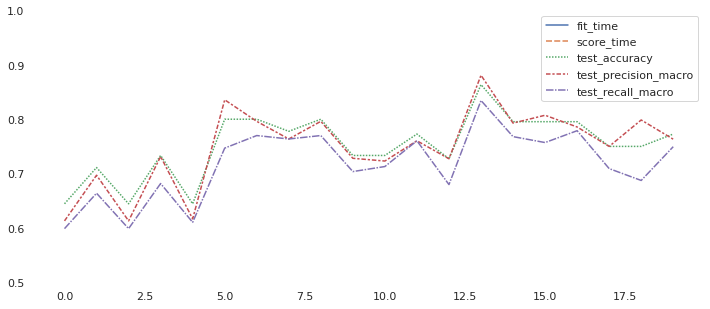

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate

metrics_models = dict()

fig = plt.figure(figsize=(15,20))

modelNB = GaussianNB()
trainX, trainY, metrics_models['Bayes'] = training_validation(modelNB, train.drop(columns={'SibSp', 'Parch'}))
modelNB.fit(trainX, trainY)

## **Training Model SVM**

 -- Accuracy -- Avg: 0.8080050505050504 Std: 0.06618633877673942
 -- Fit -- Avg: 0.023458898067474365 Std: 0.0006481880822579423
 -- Score -- Avg: 0.003424715995788574 Std: 0.00016355980409098216
 -- Recall -- Avg: 0.7861500155617802 Std: 0.0739557507028932


SVC(C=2.0, random_state=1)

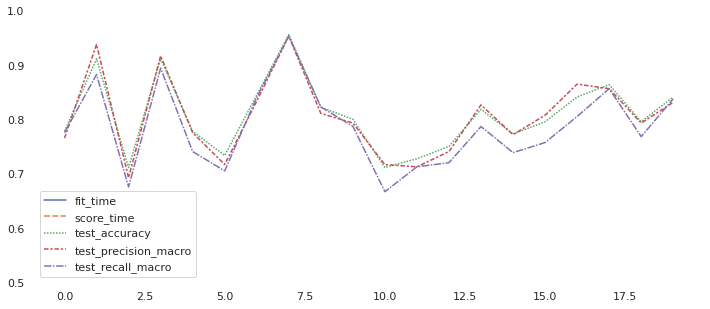

In [32]:
from sklearn.svm import SVC

modelSVM = SVC(C=2.0, gamma='scale', kernel='rbf', random_state=1)
trainX, trainY, metrics_models['SVM'] = training_validation(modelSVM, train.drop(columns={'SibSp', 'Parch'}))
modelSVM.fit(trainX, trainY)

link: https://medium.com/@msremigio/%C3%A1rvores-de-decis%C3%A3o-decision-trees-4cb6857671b3

## **Training DecisionTree Model**

 -- Accuracy -- Avg: 0.8214646464646466 Std: 0.061764290399999325
 -- Fit -- Avg: 0.0017432212829589845 Std: 0.00027421073548954757
 -- Score -- Avg: 0.0018823027610778808 Std: 0.00022540734120089377
 -- Recall -- Avg: 0.8009278711484594 Std: 0.0703983172590269


DecisionTreeClassifier(max_depth=4, max_leaf_nodes=30, random_state=10)

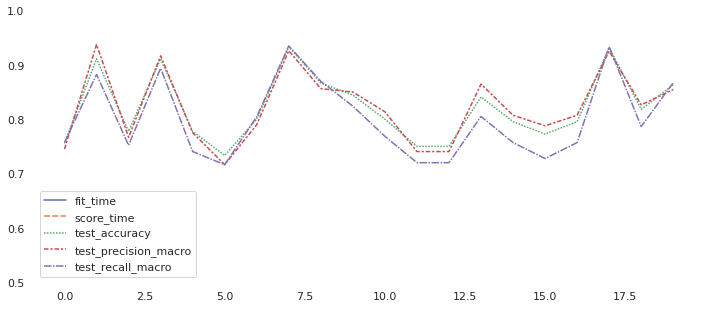

In [16]:
from sklearn.tree import DecisionTreeClassifier as DTC

modelDTC = DTC(max_depth=4, random_state=10, max_leaf_nodes=30)
trainX, trainY, metrics_models['DecisionTree'] = training_validation(modelDTC, train)
modelDTC.fit(trainX, trainY)

## **Training RandomForestModel**

 -- Accuracy -- Avg: 0.8227020202020201 Std: 0.051502146060844516
 -- Fit -- Avg: 0.20506410598754882 Std: 0.0025993614027282857
 -- Score -- Avg: 0.013089370727539063 Std: 0.0005080858543171793
 -- Recall -- Avg: 0.8066098661686898 Std: 0.06468114773249209


RandomForestClassifier(criterion='entropy', random_state=0)

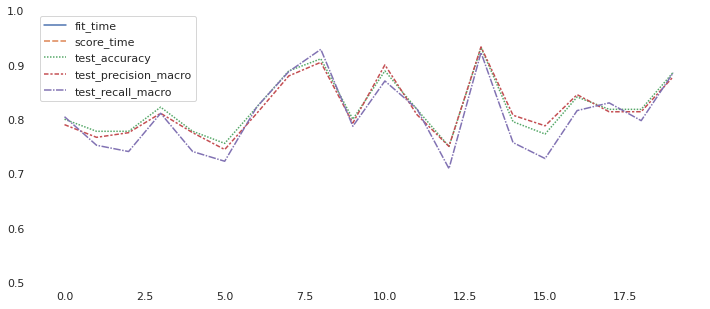

In [17]:
from sklearn.ensemble import RandomForestClassifier as RFC

modelRF = RFC(n_estimators=100, criterion='entropy', random_state=0)
trainX, trainY, metrics_models['RandomForest'] = training_validation(modelRF, train)
modelRF.fit(trainX, trainY)


## **Testing Logistic Regression Model**

 -- Accuracy -- Avg: 0.7957323232323232 Std: 0.041875197493088864
 -- Fit -- Avg: 0.006106865406036377 Std: 0.002031237967280894
 -- Score -- Avg: 0.0023705482482910155 Std: 0.0005164137320277115
 -- Recall -- Avg: 0.7788398692810456 Std: 0.047188861682936456


LogisticRegression(max_iter=200, random_state=1)

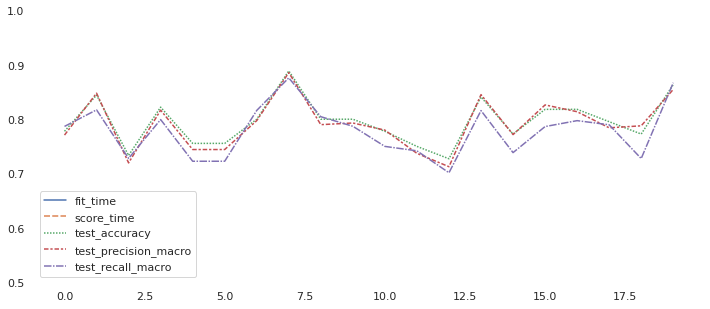

In [18]:
from sklearn.linear_model import LogisticRegression

modelLR = LogisticRegression(random_state=1, penalty="l2", max_iter=200)
trainX, trainY, metrics_models['LogisticRegression'] = training_validation(modelLR, train)
modelLR.fit(trainX, trainY)

## **Trainign XGBoost Model**
Decision Tree-based model

 -- Accuracy -- Avg: 0.8372727272727273 Std: 0.04895932608453648
 -- Fit -- Avg: 0.9953770875930786 Std: 0.3923883917864334
 -- Score -- Avg: 0.007108283042907715 Std: 0.0034094142646691754
 -- Recall -- Avg: 0.8163009648303767 Std: 0.05807338073287647


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=3,
              reg_alpha=0, reg_lambda=1, ...)

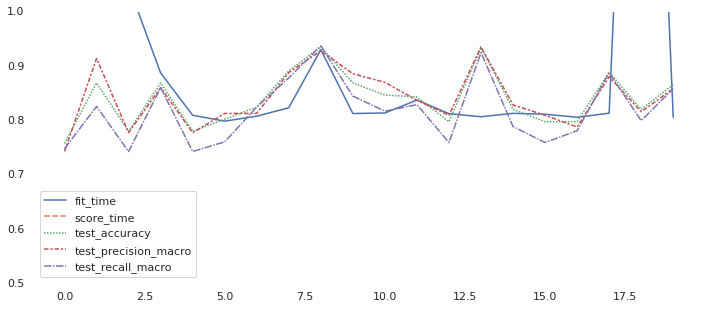

In [19]:
from xgboost import XGBClassifier as xgb

modelXGB = xgb(random_state=3, learning_rate=0.05, max_depth=4, n_estimators=200, objective="binary:logistic")
trainX, trainY, metrics_models['XGBoost'] = training_validation(modelXGB, train)

modelXGB.fit(trainX, trainY)

## **Training Light GBM Model**

Decision Tree-based model

 -- Accuracy -- Avg: 0.835151515151515 Std: 0.058928465312437714
 -- Fit -- Avg: 0.06544528007507325 Std: 0.00875336770619466
 -- Score -- Avg: 0.0030605077743530275 Std: 0.00043412503851893554
 -- Recall -- Avg: 0.815589013383131 Std: 0.07194375800143701


LGBMClassifier(learning_rate=0.05, max_depth=7, num_leaves=150,
               objective='binary')

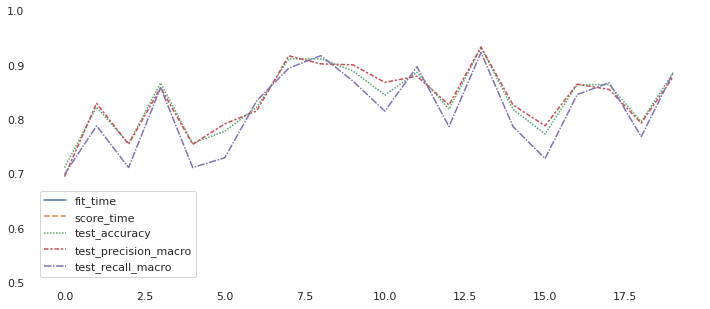

In [20]:
import lightgbm as LGBM

params = {'num_leaves': 150, 'objective': 'binary', 'max_depth': 7, 'learning_rate': .05, 'max_bin': 200}
modelLGBM = LGBM.LGBMClassifier(num_leaves=150, objective='binary', max_depth=7, learning_rate=.05)
trainX, trainY, metrics_models['LightGBM'] = training_validation(modelLGBM, train)

modelLGBM.fit(trainX, trainY)


## **Training CatBoost Model**

Decision Tree-based model, handles categorical data and non structured data.

In [21]:
import catboost as Cat
df_for_train, trainY = cleaning_missing(train)
df_for_train.drop(columns={'Sex'}, inplace=True)

modelCB = Cat.CatBoostClassifier(iterations=1, learning_rate=.05)
metrics_models['CatBoost'] = metrics_validation(modelCB, df_for_train, trainY)


0:	learn: 0.6752756	total: 59.3ms	remaining: 0us
0:	learn: 0.6755232	total: 979us	remaining: 0us
0:	learn: 0.6752402	total: 1.07ms	remaining: 0us
0:	learn: 0.6753224	total: 889us	remaining: 0us
0:	learn: 0.6751987	total: 967us	remaining: 0us
0:	learn: 0.6752100	total: 896us	remaining: 0us
0:	learn: 0.6753756	total: 948us	remaining: 0us
0:	learn: 0.6759211	total: 929us	remaining: 0us
0:	learn: 0.6753849	total: 964us	remaining: 0us
0:	learn: 0.6751402	total: 972us	remaining: 0us
0:	learn: 0.6749252	total: 924us	remaining: 0us
0:	learn: 0.6752851	total: 906us	remaining: 0us
0:	learn: 0.6769502	total: 915us	remaining: 0us
0:	learn: 0.6753544	total: 639us	remaining: 0us
0:	learn: 0.6754959	total: 907us	remaining: 0us
0:	learn: 0.6753788	total: 904us	remaining: 0us
0:	learn: 0.6757165	total: 970us	remaining: 0us
0:	learn: 0.6755740	total: 903us	remaining: 0us
0:	learn: 0.6752897	total: 979us	remaining: 0us
0:	learn: 0.6757989	total: 952us	remaining: 0us
 -- Accuracy -- Avg: 0.799090909090909

## Comparing Models

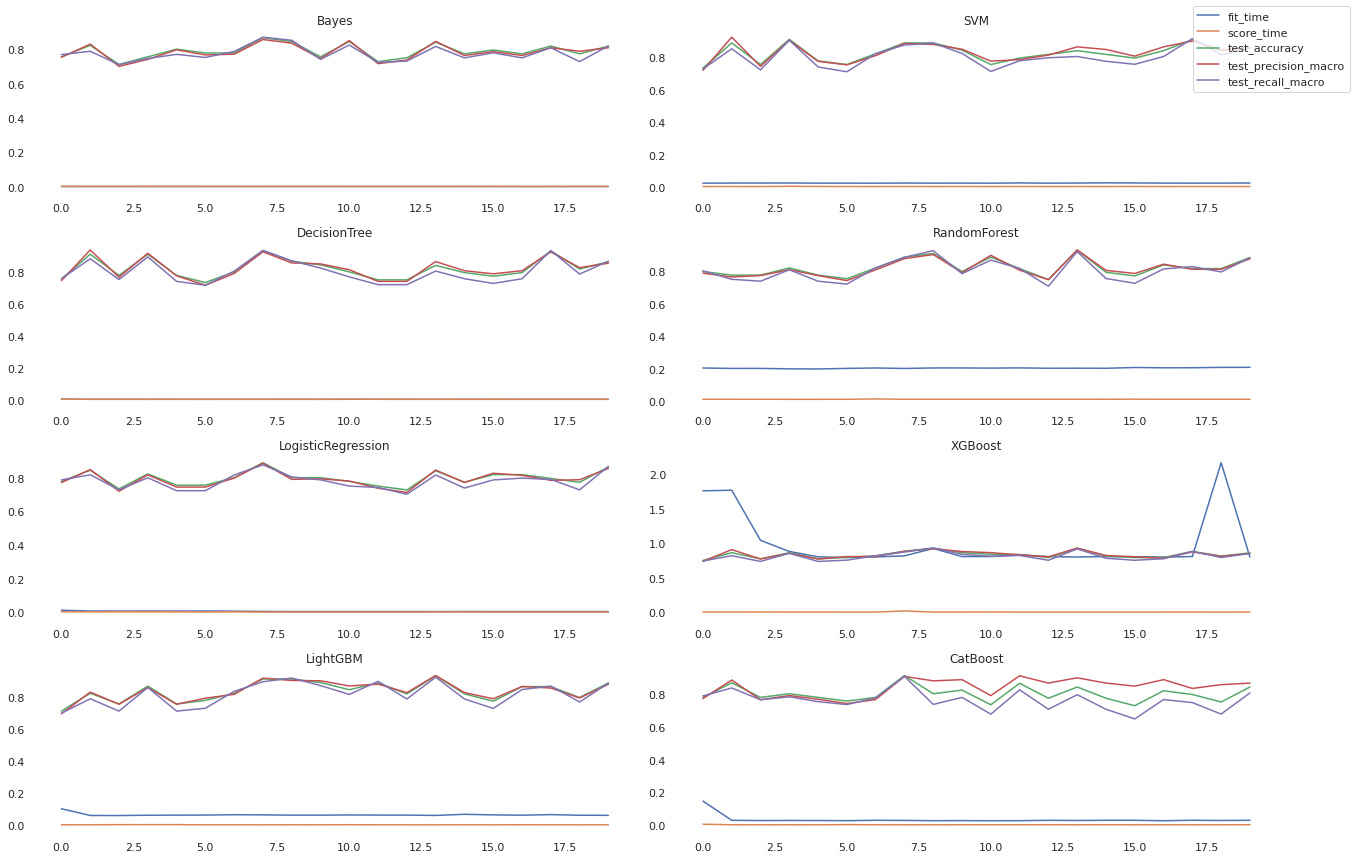

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,12))

for model in range(0, len(metrics_models)):
    name_model = list(metrics_models.keys())[model]
    plt.subplot(4, 2, model+1) # Uma figura com 3 linhas e 1 coluna
    plt.plot(pd.DataFrame(metrics_models[name_model]))
    plt.title(name_model)

fig.legend(list(metrics_models.values())[0].keys(), bbox_to_anchor=(1.05, 1), loc='upper right')

plt.tight_layout()  # Ajuste os espaços entre os subplots
plt.show()


In [23]:
metrics_df = pd.DataFrame(metrics_models).T.drop(columns={'fit_time', 'score_time'})
metrics_df.test_accuracy = metrics_df['test_accuracy'].apply(lambda x: np.mean(x))
metrics_df.test_precision_macro = metrics_df['test_precision_macro'].apply(lambda x: np.mean(x))
metrics_df.test_recall_macro = metrics_df['test_recall_macro'].apply(lambda x: np.mean(x))
metrics_df

,test_accuracy,test_precision_macro,test_recall_macro
Bayes,0.788965,0.782903,0.775547
SVM,0.827247,0.830622,0.804499
DecisionTree,0.821465,0.822381,0.800928
RandomForest,0.822702,0.819401,0.806610
LogisticRegression,0.795732,0.791172,0.778840
XGBoost,0.837273,0.839415,0.816301
LightGBM,0.835152,0.836280,0.815589
CatBoost,0.799091,0.837860,0.759594


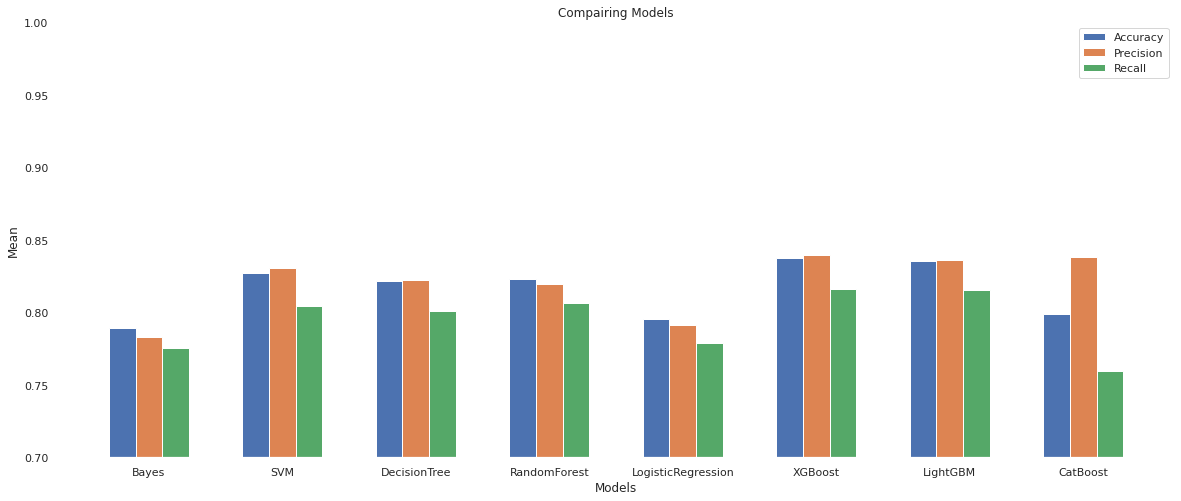

In [24]:
X = list(metrics_df.index)
fig, ax = plt.subplots(figsize=(20, 8))

X_axis = np.arange(len(X))

ax.bar(X_axis - 0.2, list(metrics_df.test_accuracy), 0.2, label='Accuracy')
ax.bar(X_axis, list(metrics_df.test_precision_macro), 0.2, label='Precision')
ax.bar(X_axis + 0.2, list(metrics_df.test_recall_macro), 0.2, label='Recall')

ax.set_xticks(X_axis)
ax.set_xticklabels(X)
ax.set_ylim(0.7, 1.0)

ax.set_xlabel("Models")
ax.set_ylabel("Mean")
ax.set_title("Compairing Models")
ax.legend()

plt.show()

## Choosing the Model

In [42]:
test['SBin'] = test['Sex'].apply(lambda x: 1 if x == 'male' else 0)
testX, _ = data_preparation(test)
predictions = modelXGB.predict(testX)

In [48]:
df_predicted = pd.DataFrame(predictions).set_index(test['PassengerId'])
df_predicted

,0
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0
